In [1]:
from IPython.core.display import display, HTML
# Full display of notebook (width of screen)
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import basic libraries
import os, glob, sys
import numpy as np   
import pandas as pd 

# Define librearies needed for analysis
import matplotlib.pyplot as plt # Matplotlibrary
import seaborn as sns # Seaborn Library

# Plotting pretty figures
import itertools
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.size']       = 19
plt.rcParams['figure.figsize']  = (12.0, 7.0)
plt.rcParams['lines.linewidth'] = 2

SMALL_SIZE = 19
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font',  size = SMALL_SIZE)
plt.rc('axes',  titlesize = MEDIUM_SIZE)
plt.rc('xtick', labelsize = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('axes',  linewidth = 2)

params = {
            'xtick.major.width': 2.15,
            'xtick.minor.width': 1.25,
            'xtick.major.size': 8,
            'xtick.minor.size': 3.5,
            'ytick.major.width': 2.15,
            'ytick.minor.width': 1.25,
            'ytick.major.size': 8,
            'ytick.minor.size': 3.5
         }

plt.rcParams.update(params)

feat_path = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))))
if feat_path not in sys.path:
    sys.path.append(feat_path)
    
%load_ext autoreload
%autoreload 2

np.random.seed(42)

# get additional tools
from src.utils import utils 

# Define path where data is located and folder to access to it
path_data = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))),'data','external')

# 1. Data pre-processing

In [2]:
# load data in pd dataframe
train = pd.read_csv(os.path.join(path_data,'train.csv'))
test = pd.read_csv(os.path.join(path_data,'test.csv'))

# Modify
to_drop = ['PassengerId','SibSp','Parch', 'Ticket', 'Cabin' ,'Name']

train = utils.pipeline_features(train, to_drop)
test = utils.pipeline_features(test, to_drop)

In [3]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title,Deck
0,0,3,0,1,0,0,2,2,7
1,1,1,1,2,3,1,2,3,2
2,1,3,1,1,1,0,1,1,7
3,1,1,1,2,3,0,2,3,2
4,0,3,0,2,1,0,1,2,7


In [4]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title,Deck
0,0,3,0,1,0,0,2,2,7
1,1,1,1,2,3,1,2,3,2
2,1,3,1,1,1,0,1,1,7
3,1,1,1,2,3,0,2,3,2
4,0,3,0,2,1,0,1,2,7


In [5]:
#pip list

# 2. features selection

In [6]:
from src.features.feature_selector import FeatureSelector

train_labels = train['Survived']
train_ = train.drop(columns = ['Survived'])

fs = FeatureSelector(data = train_, labels = train_labels)

In [7]:
fs.identify_single_unique()

0 features with a single unique value.



In [8]:
fs.identify_collinear(correlation_threshold=0.95)

0 features with a correlation magnitude greater than 0.95.



In [9]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']
# dataframe of collinear features
collinear_features

[]

In [10]:
# Collinear plot of all maximally correlated features
#fs.identify_collinear(correlation_threshold=0.96)
#fs.plot_collinear()

In [11]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'multi_logloss', 
                            n_iterations = 10, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.359541
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.255246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.423482
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.372212
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.391853
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.345351
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.300631
Train

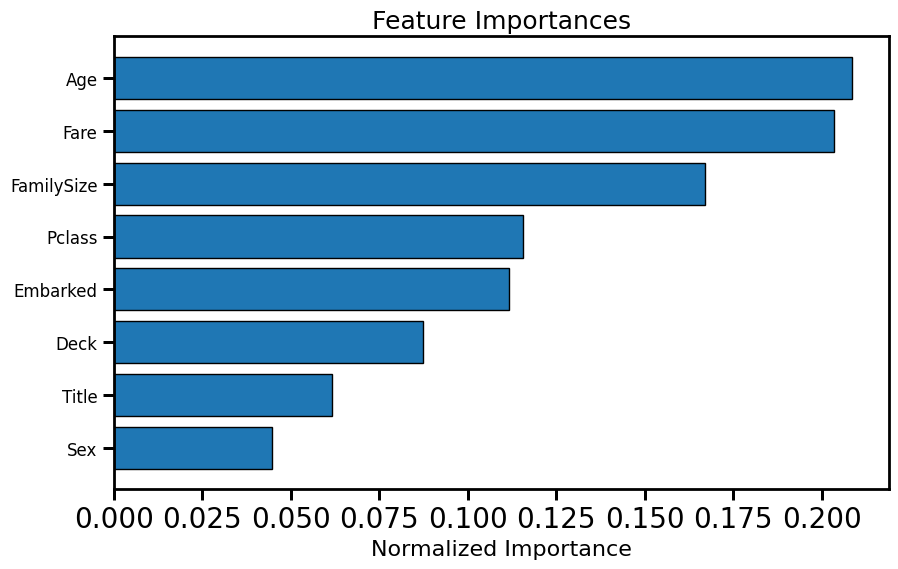

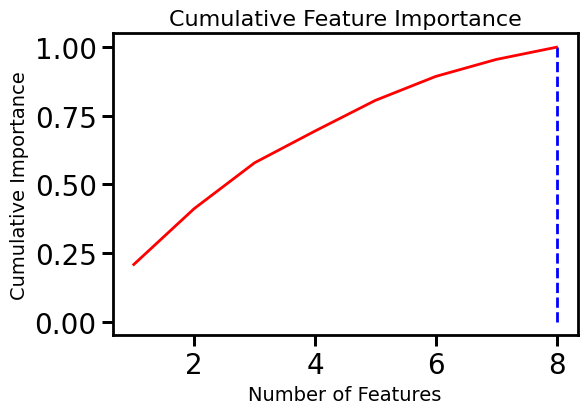

8 features required for 0.99 of cumulative importance


In [12]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 8)

In [13]:
# gather all identified features for for removal
remove = fs.check_removal()

Total of 0 features identified for removal


In [14]:
# Remove features suggested for Training and Testing data
X_train = train.drop(np.intersect1d(remove, train.keys()), axis=1)
X_test  = test.drop(np.intersect1d(remove, test.keys()), axis=1)

In [15]:
Y_train = X_train['Survived']
X_train = X_train.drop(columns = ['Survived'])

# 3. Baseline CV = 5

In [16]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
# ML models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier # Generic Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import SVC # Support Vector machine
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report

# Calculate Baseline
abc = AdaBoostClassifier(RandomForestClassifier(random_state=24), algorithm="SAMME.R")
rfc = RandomForestClassifier(random_state=24, n_jobs = -1)
dtc = DecisionTreeClassifier(random_state=24)
xgbo = XGBClassifier(random_state=24, n_jobs = -1)
lgbw = LGBMClassifier(learning_rate = 0.05, n_jobs=-1)
sgd = SGDClassifier(loss=  "log", random_state=24, n_jobs = -1)
svc = SVC(probability=True, random_state=24)
lrc = LogisticRegression(random_state=24, n_jobs = -1)
knc = KNeighborsClassifier(n_jobs = -1, n_neighbors = 3)
nb = GaussianNB()

# Models
clfs = {'NB'      : nb,
        'DT'      : dtc,
        'SGD'     : sgd,
        'LR'      : lrc,
        'DT'      : dtc,
        'RF'      : rfc,
        'KN'      : knc,
        'lgb'     : lgbw,
        'XGB'     : xgbo, 
        'AdaBoost': abc
        }

for name, model in clfs.items():
    
    print("Classifier: {}".format(name))
    
    # compute benchmark

    results  = cross_val_score(model, X_train, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')
    results2 = cross_val_score(model, X_train, Y_train, scoring=make_scorer(f1_score, average='weighted'), cv=StratifiedKFold(n_splits=5) )
    
    print(r"Acc : ({:.2f} +- {:.2f})%".format(  results.mean() * 100, results.std() * 100))
    print(r"F1_w: ({:.2f} +- {:.2f})%".format( results2.mean() * 100, results2.std() * 100))
    print("")

Classifier: NB
Acc : (79.02 +- 2.52)%
F1_w: (79.24 +- 2.45)%

Classifier: DT
Acc : (80.58 +- 2.05)%
F1_w: (80.34 +- 2.03)%

Classifier: SGD
Acc : (69.49 +- 10.91)%
F1_w: (66.00 +- 13.28)%

Classifier: LR
Acc : (77.67 +- 2.03)%
F1_w: (77.55 +- 2.05)%

Classifier: RF
Acc : (81.48 +- 3.56)%
F1_w: (81.30 +- 3.67)%

Classifier: KN
Acc : (80.13 +- 2.40)%
F1_w: (80.08 +- 2.24)%

Classifier: lgb
Acc : (81.93 +- 3.37)%
F1_w: (81.66 +- 3.55)%

Classifier: XGB
Acc : (81.26 +- 3.60)%
F1_w: (81.03 +- 3.74)%

Classifier: AdaBoost
Acc : (80.92 +- 1.87)%
F1_w: (80.39 +- 2.94)%



# 4. Data Transformation

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from pandas import DataFrame

# Create a class to select numerical or categorical columns
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

def data_transf(df, features_num, trans_num, scaling_num, features_cat, trans_cat):
    """
    Keyword arguments:
    df                  -- dataframe
    features_num        -- features to transform
                        
    transformation      -- specific wat to deal with skenwess
    scaling             -- numeric scaling 
    -----------------------------------------
    Returns:  new_df
    """

    num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(features_num)),  # select only num_attribs
        #('num_encoding', None),  
        ('num_encoding', OneHotEncoder())        
    ])
    cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(features_cat)),  # select only num_attribs
        ('cat_encoding', None)        
    ])
    
        # Process full pipeline
    preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),  # numerical attributes
    ])
    # data transformation  accoding to pipeline
    X = preprocess_pipeline.fit_transform(df)

    return DataFrame(X)



In [18]:
# get numeric features
keys_dropping = []
features_num = X_train.drop(keys_dropping, axis=1).select_dtypes(include=np.number).columns.tolist()
features_num

['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'Title', 'Deck']